# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(42)

In [2]:
DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./language_model_wiki/LM')

TWEETSLM_PATH=Path('./LM_tweets')

CLAS_PATH=Path('./tweets_class')

PRE_FINETUNE_PATH=Path('./LM_fine_tune')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [3]:
df = pd.read_csv(DATA_PATH/'corpus_completo_5_temas_08-sep-2016-codificacion_5_temas.csv')

In [4]:
print(df.shape)
print(df.columns.values)
print(df['Texto'].isnull().any())
print(df['Tema_05'].isnull().any())
print(df['Tema_05'].value_counts())

(3116, 5)
['Num' 'Id Tweet' 'Fecha Publicacion' 'Texto' 'Tema_05']
False
False
2     1102
1      738
9      718
11     359
10     199
Name: Tema_05, dtype: int64


In [5]:
# encode lables
df['Tema_05'] = df['Tema_05'].replace([1, 2, 9, 10, 11], [1, 2, 3, 4, 5])
print(df['Tema_05'].value_counts())

2    1102
1     738
3     718
5     359
4     199
Name: Tema_05, dtype: int64


In [6]:
tweets = df['Texto'].values
labels = df['Tema_05'].values
LABELS = set(labels)

In [7]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               #else 'user_ref' if i.startswith('@') 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for Hashtags
    tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

   
    
    return tweets



In [8]:
tweets = preprocess_tweets(tweets)

In [9]:
col_names = ['label', 'tweet']

In [10]:
tweets_train, tweets_test, labels_train, labels_test = train_test_split(
                                                    tweets, labels,
                                                    stratify=labels, 
                                                    test_size=0.20)

tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
                                                    tweets_train, labels_train,
                                                    stratify=labels_train, 
                                                    test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_test.shape, labels_test.shape)

train shapes: (2242,) (2242,)
valid shapes: (250,) (250,)
test shapes: (624,) (624,)


In [11]:
df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_test, 'label':labels_test}, columns=col_names)

In [12]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

2    794
1    531
3    516
5    258
4    143
Name: label, dtype: int64
2    88
1    59
3    58
5    29
4    16
Name: label, dtype: int64
2    220
1    148
3    144
5     72
4     40
Name: label, dtype: int64


In [13]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

5    794
3    794
1    794
4    794
2    794
Name: label, dtype: int64
2    88
1    59
3    58
5    29
4    16
Name: label, dtype: int64
2    220
1    148
3    144
5     72
4     40
Name: label, dtype: int64


In [14]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

### Create dataframes for Language Model fine-tuning

In [15]:
tweets_lm = np.concatenate([tweets_train, tweets_valid, tweets_test])
labels_lm = np.concatenate([labels_train, labels_valid, labels_test])

tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split(
                                                    tweets_lm, labels_lm,
                                                    stratify=labels_lm, 
                                                    test_size=0.10)

In [16]:
df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

In [17]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [18]:
df_trn.shape, df_val.shape

((2804, 2), (312, 2))

## Tokenize and Standarize General Tokens


In [27]:
chunksize=24000

re1 = re.compile(r'  +')

In [28]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [21]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [22]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [23]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(2804, 2804, 312, 312)

In [24]:
print(tok_trn[:2])

[['\n', 'xbos', '@ahorapodemos', '@ierrejon', 'totalmente', 'de', 'acuerdo', ',', 'pero', 'son', 'grandes', 'manippuladores.expertos', 'en', 'guerra', 'sucia', 'y', 'con', 'grandes', 'medios.adelante', '.'], ['\n', 'xbos', 'rt', '@eldiarioes', ':', 'rivera', ':', '"', 'me', 'río', 'un', 'rato', 'cuando', 'me', 'dicen', 'que', 'somos', 'el', 'partido', 'del', 'ibex', '"', 'hyp_link', 'hyp_link']]


In [25]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [26]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [27]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [28]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 2804),
 ('xbos', 2804),
 (':', 2725),
 ('t_up', 2261),
 ('hyp_link', 2056),
 ('de', 2055),
 ('#', 2009),
 ('hash_tag', 1987),
 ('rt', 1959),
 ('el', 1603),
 ('que', 1359),
 ('.', 1319),
 ('la', 1285),
 ('a', 1272),
 (',', 1259),
 ('y', 1094),
 ('en', 1093),
 ('"', 994),
 ('no', 707),
 ('los', 571)]

In [77]:
max_vocab = 60000
min_freq = 1

In [78]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3569

In [79]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [80]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [3]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [4]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [5]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [6]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [7]:
em_sz,nh,nl = 400,1150,3

In [8]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [9]:
vs=len(itos)
vs,len(trn_lm)

(3569, 2804)

In [10]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 3356 word embeddings from fine-tuning
213 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [11]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [12]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [13]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [14]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [15]:
#drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [16]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [17]:
learn.model.load_state_dict(wgts)

In [18]:
learn.lr_find2(start_lr=1e-1,end_lr=3e-1, num_it=300)

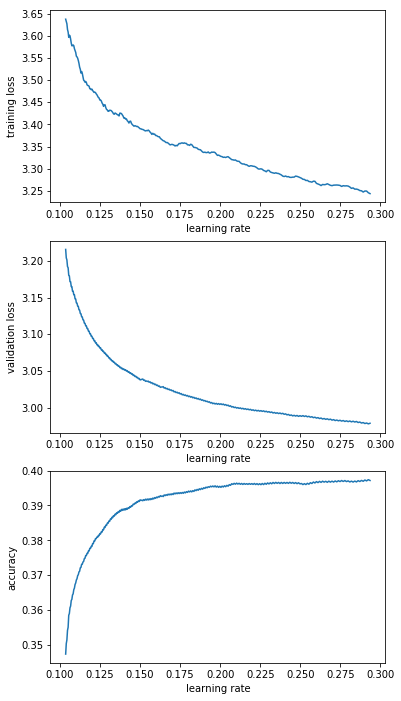

In [19]:
learn.sched.plot()

In [20]:
lr= 12e-2
lrs = lr

In [21]:
learn.clip=0.12

In [22]:
learn.fit(lr, 2, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                 
    0      3.512094   3.143803   0.361683  
    1      3.463854   3.109608   0.370076                 
    2      3.424736   3.081873   0.37387                  
    3      3.394829   3.04915    0.380063                 
    4      3.374648   3.046742   0.381777                 
    5      3.356267   3.033215   0.387061                 
    6      3.346115   3.029274   0.388473                 
    7      3.346055   3.03861    0.384868                 
    8      3.341172   3.017115   0.390713                 
    9      3.335366   3.032818   0.385621                 
    10     3.335254   3.020991   0.389409                 
    11     3.323995   3.013379   0.389844                 
    12     3.315387   3.015023   0.390625                 
    13     3.304528   3.00829    0.390722                 
    14     3.297402   3.004618   0.39092                  
    15     3.289839   2.999266   0.395143                 
    16     3

[array([2.98832]), 0.3985252778851584]

In [23]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [24]:
chunksize=24000

re1 = re.compile(r'  +')

In [25]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [29]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [30]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [31]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [32]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

In [33]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [34]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3569

In [35]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [36]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

In [37]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [38]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [39]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [40]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [41]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [42]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [43]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [44]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [45]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [46]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [47]:
learn.freeze_to(-1)

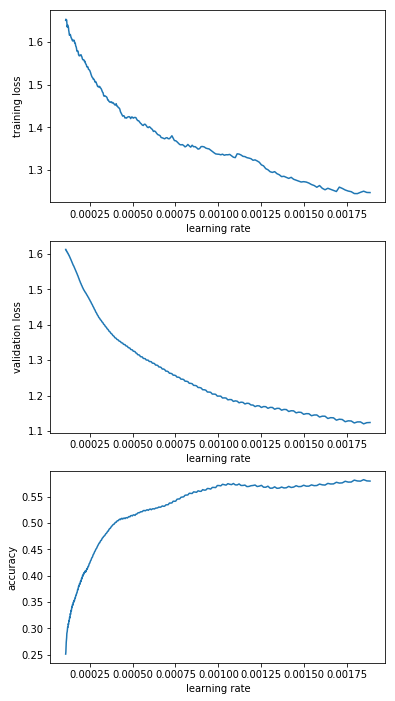

In [48]:
learn.lr_find2(start_lr=1e-4,end_lr=2e-3, num_it=300)
learn.sched.plot()

In [49]:
lr= 6e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [50]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy                 
    0      1.488677   1.34094    0.502495  
    1      1.387118   1.234598   0.546618                 
    2      1.312703   1.137717   0.620914                 
    3      1.265535   1.107144   0.612576                 


[array([1.10714]), 0.6125756885324206]

In [51]:
learn.load('clas2_0')

In [52]:
learn.freeze_to(-2)

In [53]:
learn.fit(lrs, 8, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy                 
    0      1.235413   1.101505   0.602274  
    1      1.226216   1.101165   0.595277                 
    2      1.202811   1.05636    0.628502                 
    3      1.143528   1.049464   0.627495                 
    4      1.180812   1.026346   0.613807                 
    5      1.158619   1.029651   0.631889                 
    6      1.124048   1.033859   0.568824                 
    7      1.123336   1.021324   0.575373                 


[array([1.02132]), 0.5753733026129859]

In [54]:
learn.load('clas2_1')

In [55]:
learn.unfreeze()

In [56]:
learn.fit(lr, 2, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy                 
    0      1.129126   0.999955   0.603981  
    1      1.064518   0.935651   0.637655                 
    2      0.966681   0.882731   0.652126                  
    3      0.86542    0.883413   0.643306                  
    4      0.80838    0.872838   0.671804                  
    5      0.797952   0.841629   0.656327                  
    6      0.729612   0.824696   0.662318                  
    7      0.663911   0.836466   0.679841                  
    8      0.612505   0.820628   0.685274                  
    9      0.57248    0.805872   0.700527                  


[array([0.80587]), 0.7005272507667542]

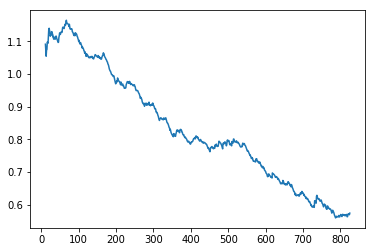

In [57]:
learn.load('final')
learn.sched.plot_loss()

## Model Evaluation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1(macro) =  0.7308588062526968
Accuracy  =  0.75


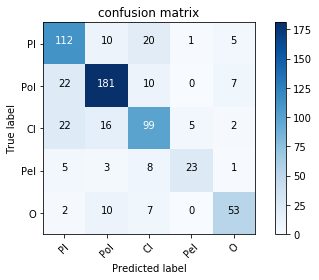

In [4]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()